# 4DSTEM scan builder

In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import time


import sys
sys.path.insert(0,'..')
from gausscount import counting
from gausscount import profile

In [2]:
def extract_electron_pattern(df, evt, center_row=50, center_col=50, window_size=101):
    half_window = window_size // 2
    pattern_df = df[df.event == evt]
    pattern_df = pattern_df[(pattern_df['row'].between(center_row - half_window, center_row + half_window)) &
                    (pattern_df['col'].between(center_col - half_window, center_col + half_window))]
    
    electron_pattern = np.zeros((window_size, window_size), dtype=int)
    for _, hit in pattern_df.iterrows():
        electron_pattern[hit['row'] - (center_row - half_window),
                         hit['col'] - (center_col - half_window)] += hit['counts']
    return electron_pattern

def generate_and_save_frames(hit_positions_per_frame, multiplicities_per_frame, df, nframes, frame_size, output_filename, baseline=20, noise_sigma=1, mc_scale=1):
    """
    Generates Monte Carlo frames based on hit positions and multiplicities for each frame, adds baseline and noise, 
    and saves them in an HDF5 file. Also saves the Monte Carlo "truth" data.
    
    Args:
    - hit_positions_per_frame (list of list of tuples): List of hit positions for each frame. 
        Each element is a list of (x, y) tuples for the corresponding frame.
    - multiplicities_per_frame (list of list of ints): List of multiplicities for each frame. 
        Each element is a list of multiplicities corresponding to the hit positions in the same frame.
    - df (DataFrame): DataFrame containing electron patterns.
    - nframes (int): Number of frames to generate.
    - frame_size (int): Size of each frame (e.g., 576 for 576x576 frames).
    - output_filename (str): Name of the output HDF5 file.
    - baseline (int or float): Baseline value to be added to each pixel in the frames.
    - noise_sigma (float): Standard deviation of the Gaussian noise to be added (mean = 0).
    - mc_scale (float): Scale factor to apply to MC pixel amplitudes.
    
    Returns:
    - None: Saves the generated frames and the Monte Carlo "truth" in the specified HDF5 file.
    """
    
    # Initialize an empty array to store the generated frames and the Monte Carlo truth
    frames = np.zeros((nframes, frame_size, frame_size), dtype=np.uint32)
    mc_truth = np.zeros((nframes, frame_size, frame_size), dtype=np.uint32)
    
    # Obtain unique events to choose from
    unique_events = df['event'].unique()
    
    for i in range(nframes):
        hit_positions = hit_positions_per_frame[i]
        multiplicities = multiplicities_per_frame[i]
        
        for (x, y), multiplicity in zip(hit_positions, multiplicities):
            
            for ielec in range(multiplicity):
                
                # Randomly select an event to get the electron pattern
                evt = random.choice(unique_events)
                electron_pattern = extract_electron_pattern(df, evt)

                # Determine the position of the top-left corner where the electron pattern will be positioned
                half_window = len(electron_pattern) // 2
                top_left_x = x - half_window
                top_left_y = y - half_window

                # Calculate the bounds of the pattern slice within the frame
                start_i = max(0, -top_left_x)
                start_j = max(0, -top_left_y)
                end_i = min(frame_size - top_left_x, len(electron_pattern))
                end_j = min(frame_size - top_left_y, len(electron_pattern))

                # Calculate the frame slice where the pattern will be added
                frame_slice_x_start = max(0, top_left_x)
                frame_slice_y_start = max(0, top_left_y)
                frame_slice_x_end = frame_slice_x_start + (end_i - start_i)
                frame_slice_y_end = frame_slice_y_start + (end_j - start_j)

                # Add the electron pattern slice to the current frame
                frames[i, frame_slice_x_start:frame_slice_x_end, frame_slice_y_start:frame_slice_y_end] += \
                    (electron_pattern[start_i:end_i, start_j:end_j]*mc_scale).astype(np.uint32)
                
                # Update the Monte Carlo "truth" frame only at the exact hit location
                mc_truth[i, x, y] += np.uint32(1)
    
    # Add baseline and noise to the frames
    frames = frames + baseline
    noise = np.random.normal(0, noise_sigma, frames.shape)
    frames = frames + noise
    #frames = np.clip(frames + noise, 0, 65535).astype(np.uint32)  # Ensure values stay within uint32 range
    
    # Save the frames and Monte Carlo "truth" in an HDF5 file
    with h5py.File(output_filename, 'w') as h5file:
        h5file.create_dataset('/frames', data=frames, compression="gzip")
        h5file.create_dataset('/truth', data=mc_truth, compression="gzip")
        
# Function to load the data and plot a frame alongside the MC truth with zoom options
def plot_frame_and_mc_truth(hdf5_filename, frame_index=0, x_range=None, y_range=None):
    """
    Load and plot a specific frame alongside the Monte Carlo truth from the HDF5 file with optional zoom.
    
    Args:
    - hdf5_filename (str): The path to the HDF5 file.
    - frame_index (int): The index of the frame to plot.
    - x_range (tuple of ints): The range in the x-axis to zoom in on (start, end). Default is the full range.
    - y_range (tuple of ints): The range in the y-axis to zoom in on (start, end). Default is the full range.
    
    Returns:
    - None: Displays the plots.
    """
    # Open the HDF5 file
    with h5py.File(hdf5_filename, 'r') as h5file:
        # Load the specific frame
        frame = h5file['/frames'][frame_index]
        
        # Load the Monte Carlo truth
        mc_truth = h5file['/truth'][frame_index]
        #mc_truth = np.zeros([101,101])
    
    # Determine the zoom range (default is full range)
    if x_range is None:
        x_range = (0, frame.shape[1])
    if y_range is None:
        y_range = (0, frame.shape[0])
    
    # Apply zoom
    frame_zoomed = frame[y_range[0]:y_range[1], x_range[0]:x_range[1]]
    mc_truth_zoomed = mc_truth[y_range[0]:y_range[1], x_range[0]:x_range[1]]
    
    # Plot the frame and the Monte Carlo truth
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot the zoomed frame
    im0 = axs[0].imshow(frame_zoomed, cmap='viridis', extent=(x_range[0], x_range[1], y_range[1], y_range[0]))
    axs[0].set_title(f'Frame {frame_index} (Zoomed)')
    axs[0].axis('off')
    fig.colorbar(im0, ax=axs[0], orientation='vertical')
    
    # Plot the zoomed Monte Carlo truth
    im1 = axs[1].imshow(mc_truth_zoomed, cmap='viridis', extent=(x_range[0], x_range[1], y_range[1], y_range[0]))
    axs[1].set_title('Monte Carlo Truth (Zoomed)')
    axs[1].axis('off')
    fig.colorbar(im1, ax=axs[1], orientation='vertical')
    
    plt.show()

# Function to convert linear indices to 2D (row, col) indices
def linear_to_2d_indices(linear_indices, cols):
    rows = linear_indices // cols
    cols = linear_indices % cols
    return rows, cols

# Function to create a 2D image from the counted frame data
def create_counted_image(frame_data, frame_height, frame_width, weight_data = None):
    # Initialize a 2D array with zeros
    image = np.zeros((frame_height, frame_width), dtype=np.int32)

    # Convert linear indices to 2D indices
    rows, cols = linear_to_2d_indices(frame_data, frame_width)

    # Set the hit pixels
    if(not(weight_data) is None):
        for r,c,w in zip(rows,cols,weight_data):
            image[r, c] = w
    else:
        image[rows,cols] = 1

    return image

def plot_counted_vs_mc_truth(raw_file, counted_file, frame_index=0, x_range=None, y_range=None, weights=False):
    """
    Load and plot a specific raw frame, counted frame, and Monte Carlo truth with optional zoom.
    
    Args:
    - raw_file (str): The path to the raw HDF5 file containing the raw frames and Monte Carlo truth.
    - counted_file (str): The path to the HDF5 file containing the counted results.
    - frame_index (int): The index of the frame to plot.
    - x_range (tuple of ints): The range in the x-axis to zoom in on (start, end). Default is the full range.
    - y_range (tuple of ints): The range in the y-axis to zoom in on (start, end). Default is the full range.
    - weights (bool): Whether to use weights from the counted data (default: False).
    
    Returns:
    - None: Displays the plots.
    """
    # Load the raw frame and Monte Carlo truth for the selected frame
    with h5py.File(raw_file, 'r') as h5file:
        raw_frame = h5file['/frames'][frame_index]
        mc_truth_frame = h5file['/truth'][frame_index]
    
    # Load the counted data for the selected frame
    with h5py.File(counted_file, 'r') as h5file:
        frame_data = np.array(h5file['electron_events']['frames'][frame_index])
        weight_data = None
        if weights:
            weight_data = np.array(h5file['electron_events']['weights'][frame_index])
        
        # Convert the counted data into a 2D image
        frame_height = frame_width = mc_truth_frame.shape[0]
        counted_image = create_counted_image(frame_data, frame_height, frame_width, weight_data)
    
    # Determine the zoom range (default is full range)
    if x_range is None:
        x_range = (0, frame_width)
    if y_range is None:
        y_range = (0, frame_height)
    
    # Apply zoom
    counted_image_zoomed = counted_image[y_range[0]:y_range[1], x_range[0]:x_range[1]]
    mc_truth_zoomed = mc_truth_frame[y_range[0]:y_range[1], x_range[0]:x_range[1]]
    raw_frame_zoomed = raw_frame[y_range[0]:y_range[1], x_range[0]:x_range[1]]
    
    # Plot the raw frame, counted data, and Monte Carlo truth
    fig, axs = plt.subplots(1, 3, figsize=(18, 4))
    
    # Plot the zoomed raw frame
    im0 = axs[0].imshow(raw_frame_zoomed, cmap='viridis', extent=(x_range[0], x_range[1], y_range[1], y_range[0]))
    axs[0].set_title(f'Raw Frame {frame_index}')
    axs[0].axis('off')
    fig.colorbar(im0, ax=axs[0], orientation='vertical')
    
    # Plot the zoomed counted data
    im1 = axs[1].imshow(counted_image_zoomed, cmap='viridis', extent=(x_range[0], x_range[1], y_range[1], y_range[0]))
    axs[1].set_title(f'Counted Frame {frame_index} ({np.sum(counted_image)} counts)')
    axs[1].axis('off')
    fig.colorbar(im1, ax=axs[1], orientation='vertical')
    
    # Plot the zoomed Monte Carlo truth
    im2 = axs[2].imshow(mc_truth_zoomed, cmap='viridis', extent=(x_range[0], x_range[1], y_range[1], y_range[0]))
    axs[2].set_title(f'Monte Carlo Truth ({np.sum(mc_truth_frame)} counts)')
    axs[2].axis('off')
    fig.colorbar(im2, ax=axs[2], orientation='vertical')
    
    plt.show()

### Experiment: counting evaluation on MC data

In [3]:
frame_size = 101
baseline = 20
th_single_elec = 10
noise_sigma = 1
mc_scale = 0.0265

nframes_sparse = 100
nframes_occupancy = 1000
occupancies = [0.1, 1, 10]

# Load DataFrame
df_fname = "../dataframes/EM_5um_front_3M_100keV.pkl"
df = pd.read_pickle(df_fname)

##### 1. Evaluate a sparse frame to get the Gaussian profile

In [ ]:
profile_scan_file = 'sparse_frames.h5'

# Parameters
average_occupancy_sparse = 0.001  # ~0.001 hits per pixel, so ~10 electrons per frame

# Generate hit positions for sparse frames
np.random.seed(42)  # For reproducibility
total_pixels = frame_size * frame_size
total_hits_sparse = int(nframes_sparse * total_pixels * average_occupancy_sparse)

# Randomly generate hit positions and their frame indices
hit_positions_sparse = np.random.randint(0, frame_size, size=(total_hits_sparse, 2))
frame_indices_sparse = np.random.randint(0, nframes_sparse, size=total_hits_sparse)

# Convert to a list of frame-specific hit positions
hit_positions_per_frame_sparse = [[] for _ in range(nframes_sparse)]
for pos, frame_idx in zip(hit_positions_sparse, frame_indices_sparse):
    hit_positions_per_frame_sparse[frame_idx].append(tuple(pos))

# Multiplicities (all 1 for sparse hits)
multiplicities_per_frame_sparse = []
for hits in hit_positions_per_frame_sparse:
    multiplicities = []
    for i in range(len(hits)):
        multiplicities.append(1)
    multiplicities_per_frame_sparse.append(multiplicities)

# Save the generated sparse frames
generate_and_save_frames(hit_positions_per_frame_sparse, multiplicities_per_frame_sparse, df, 
                         nframes_sparse, frame_size, output_filename=profile_scan_file, 
                         baseline=baseline, noise_sigma=noise_sigma, mc_scale=mc_scale)

In [ ]:
plot_frame_and_mc_truth('sparse_frames.h5', frame_index=3, x_range=[30,60], y_range=[30,60])
#plot_frame_and_mc_truth('sparse_frames.h5', frame_index=4)
#plot_frame_and_mc_truth('frames_occupancy_1.h5', frame_index=3, x_range=[30,40], y_range=[30,40])
#plot_frame_and_mc_truth('/Volumes/nvme/lbl/emdata/raw/data_scan0000001531.h5', frame_index=5, x_range=[30,40], y_range=[30,40])

In [ ]:
avg_patch, optimized_patch, A_opt, sigma_opt = profile.gaussian_profile(profile_scan_file, nframes_sparse, baseline, th_single_elec, plot_results=True)
print(f"Determined optimal gaussian amplitude A = {A_opt}, sigma = {sigma_opt}")

##### 2. Generate frames for a single electron with different occupancies

In [ ]:
# Define the center position.
center_position = [(frame_size // 2, frame_size // 2)]

# Generate and save the concentrated hit frames for each occupancy level
for occupancy in occupancies:
    
    # Cast the multiplicities.
    # Binomial distribution with:
    # - number of trials = (occupancy) * (nframes) = avg. number of electrons per frame
    # - probability = 1/nframes, so that the average number of electrons per frame is = (occupancy*nframes)/nframes = occupancy
    # - vector size: number of frames
    multiplicities = np.random.binomial(occupancy*nframes_occupancy, 1./nframes_occupancy, nframes_occupancy)
    
    # Prepare the hit position and multiplicity arrays for each frame (each one a list of 1 element).
    hit_positions_per_frame, multiplicities_per_frame = [], []
    for iframe in range(nframes_occupancy):
        hit_positions_per_frame.append(center_position)
        multiplicities_per_frame.append([multiplicities[iframe]])
    
    print(f"Generating frames for occupancy {occupancy}...")
    generate_and_save_frames(hit_positions_per_frame, multiplicities_per_frame, df, nframes_occupancy, frame_size, output_filename=f'frames_occupancy_{occupancy}.h5', baseline=baseline, noise_sigma=noise_sigma, mc_scale=mc_scale)

In [ ]:
plot_frame_and_mc_truth('frames_occupancy_1.h5', frame_index=8, x_range=[40,60], y_range=[40,60])

##### 3. Count the frames

In [8]:
# Counting parameters
n_steps_max = 2000
frame_size = 101  # Change to 101 for concentrated frames
nframes_prior = 0
gauss_A = 16
gauss_sigma = 0.5

frames_per_batch = 1000
frames_per_batch_sparse = 100

# Perform counting on the sparse dataset
counting.count_frames('sparse_frames.h5', 'counted_sparse_frames.h5', nframes_sparse, frame_size, frames_per_batch_sparse, th_single_elec, baseline, gauss_A, gauss_sigma, n_steps_max=n_steps_max, nframes_prior=nframes_prior)#, batch_end=1)

# Perform counting on the concentrated datasets
# for occupancy in occupancies[2:3]:
#     raw_file = f'frames_occupancy_{occupancy}.h5'
#     counted_file = f'counted_frames_occupancy_{occupancy}.h5'
#     counting.count_frames(raw_file, counted_file, nframes_occupancy, frame_size, frames_per_batch, th_single_elec, baseline, gauss_A, gauss_sigma, n_steps_max=n_steps_max, nframes_prior=nframes_prior)

Analyzing in 1 batches...


 ** BATCH 0 **
-- Processing frames...
-- Counting frames...
Step 100, Loss: 105018.9921875
Step 200, Loss: 39386.39453125
Step 300, Loss: 17791.7109375
Step 400, Loss: 8804.9140625
Step 500, Loss: 4557.67919921875
Step 600, Loss: 2393.81494140625
Step 700, Loss: 1250.1331787109375
Step 800, Loss: 641.683349609375
Step 900, Loss: 322.279296875
Step 1000, Loss: 158.46804809570312
Counted in n_steps = 1064 with loss = 99.83573150634766
-- Saving frames...
Frame indices len = 100 and weights = 100


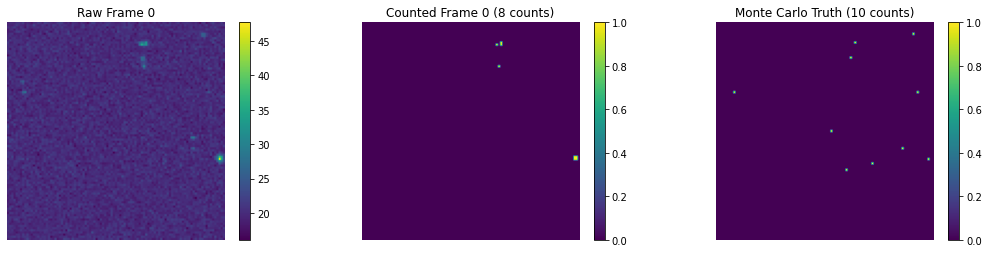

In [9]:
#plot_counted_vs_mc_truth('frames_occupancy_10.h5', 'counted_frames_occupancy_10.h5', frame_index=3, weights=True)#, x_range=[30,60], y_range=[30,60])
#plot_counted_vs_mc_truth('sparse_frames.h5', 'counted_sparse_frames.h5', frame_index=3, weights=True, x_range=[30,60], y_range=[30,60])
plot_counted_vs_mc_truth('sparse_frames.h5', 'counted_sparse_frames.h5', frame_index=0, weights=True)

##### 4. Examine the results

In [ ]:
def evaluate_counting_results(raw_file, counted_file, frame_size=101, weights=False, x_range=None, y_range=None):
    """
    Evaluate counting results by comparing the summed counted frames to the MC truth.
    Generates a 2D heatmap for comparison.
    
    Args:
    - raw_file (str): Path to the raw HDF5 file containing the MC truth.
    - counted_file (str): Path to the HDF5 file containing the counted results.
    - frame_size (int): Size of the frames (default: 101).
    - weights (bool): Whether to use weights from the counted data (default: False).
    - x_range (tuple of ints): The range in the x-axis to zoom in on (start, end). Default is the full range.
    - y_range (tuple of ints): The range in the y-axis to zoom in on (start, end). Default is the full range.
    
    Returns:
    - None: Displays the heatmaps of the MC truth and the counted results.
    """
    # Get the MC truth from the raw file and sum all hits.
    with h5py.File(raw_file, 'r') as h5file:
        mc_truth = h5file['/truth'][:]
    summed_mc_truth = np.sum(mc_truth, axis=0)
    
    # Sum the counted frames
    with h5py.File(counted_file, 'r') as h5file:
        
        nframes = len(np.array(h5file['electron_events']['frames']))
        print(f"Found {nframes} counted frames")
        
        summed_counted_frames = np.zeros((frame_size, frame_size), dtype=np.int32)
        nelec = 0
        for iframe in range(nframes):
            frame_data = np.array(h5file['electron_events']['frames'][iframe])
            weight_data = None
            if(weights):
                weight_data = np.array(h5file['electron_events']['weights'][iframe])

            # Create a 2D image of the counted frame
            counted_image = create_counted_image(frame_data, frame_size, frame_size, weight_data)

            # Sum the counted images
            summed_counted_frames += counted_image
            nelec += len(frame_data)

    # Determine the zoom range (default is full range)
    if x_range is None:
        x_range = (0, frame_size)
    if y_range is None:
        y_range = (0, frame_size)
    
    # Apply zoom
    summed_mc_truth_zoomed = summed_mc_truth[y_range[0]:y_range[1], x_range[0]:x_range[1]]
    summed_counted_frames_zoomed = summed_counted_frames[y_range[0]:y_range[1], x_range[0]:x_range[1]]
    
    # Plot 2D heatmaps
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    
    # MC truth heatmap
    im0 = axs[0].imshow(summed_mc_truth_zoomed, cmap='viridis', origin='lower', interpolation='none', extent=(x_range[0], x_range[1], y_range[1], y_range[0]))
    axs[0].set_title(f'Summed MC Truth (total {np.sum(summed_mc_truth)})')
    fig.colorbar(im0, ax=axs[0], orientation='vertical')
    
    # Counted result heatmap
    im1 = axs[1].imshow(summed_counted_frames_zoomed, cmap='viridis', origin='lower', interpolation='none', extent=(x_range[0], x_range[1], y_range[1], y_range[0]))
    axs[1].set_title(f'Summed counted frames (total {np.sum(summed_counted_frames)})')
    fig.colorbar(im1, ax=axs[1], orientation='vertical')
    print(summed_counted_frames[50,:])
    
    plt.show()
    
    # Plot the results (1D)
    # Extract the line through the center (50,50)
    center = frame_size // 2
    counted_line = summed_counted_frames[center, :]
    truth_line = summed_mc_truth[center, :]
    plt.figure(figsize=(10, 5))
    plt.plot(counted_line, label='Counted')
    plt.plot(truth_line, label='MC Truth', linestyle='--')
    plt.title('Counted vs. MC Truth (Line Through Center)')
    plt.xlabel('Pixel')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True)
    plt.show()

# Evaluate the sparse counting results
#evaluate_counting_results('sparse_frames.h5', 'counted_sparse_frames.h5')
evaluate_counting_results('frames_occupancy_10.h5', 'counted_frames_occupancy_10.h5', weights=True)#, x_range=[45,55], y_range=[45,55])

##### Test: save some frames and examine them

In [ ]:
# Load DataFrame
df_fname = "../dataframes/EM_5um_front_3M_100keV.pkl"
df = pd.read_pickle(df_fname)

# Specify hit positions and multiplicities
nframes = 10
hit_positions = [(50, 50), (60, 40)]
hit_positions_per_frame = [hit_positions for _ in range(nframes)]
multiplicities = [10, 20] * nframes  # Corresponding multiplicities for each hit position
multiplicities_per_frame = [multiplicities for _ in range(nframes)]

# Generate and save the frames with baseline and noise, and save the Monte Carlo truth
generate_and_save_frames(hit_positions_per_frame, multiplicities_per_frame, df, nframes=nframes, frame_size=576, output_filename='generated_frames_with_truth.h5', baseline=20, noise_sigma=1)

In [ ]:
plot_frame_and_mc_truth('generated_frames_with_truth.h5', frame_index=0, x_range=[30,80], y_range=[30,80])

In [ ]:
# Generate a sparse frame for testing Gaussian determination
# Generate several hit points with varying average occupancy (3-4 points?) and count them

## Old code

In [ ]:
# Old frame creation function
def create_frame(n, hit_positions, df):
    frame = np.zeros((n, n), dtype=int)
    
    # Obtain unique events to choose from
    unique_events = df['event'].unique()
    
    # Position each electron hit in the frame
    for x, y in hit_positions:
        evt = random.choice(unique_events)  # Randomly select an event
        electron_pattern = extract_electron_pattern(df, evt)
        
        # Get the electron pattern size
        whole_window = len(electron_pattern)

        # Determine the position of the top-left corner where the electron pattern will be positioned (assuming it fits).
        half_window = whole_window // 2
        top_left_x = x - half_window
        top_left_y = y - half_window

        # Calculate the bounds of the pattern slice within the frame
        start_i = max(0, -top_left_x)
        start_j = max(0, -top_left_y)
        end_i = min(n - top_left_x, whole_window)
        end_j = min(n - top_left_y, whole_window)

        # Calculate the frame slice where the pattern will be added
        frame_slice_x_start = max(0, top_left_x)
        frame_slice_y_start = max(0, top_left_y)
        frame_slice_x_end = frame_slice_x_start + (end_i - start_i)
        frame_slice_y_end = frame_slice_y_start + (end_j - start_j)

        # Add the electron pattern slice to the frame slice
        frame[frame_slice_x_start:frame_slice_x_end, frame_slice_y_start:frame_slice_y_end] += \
            electron_pattern[start_i:end_i, start_j:end_j]
    
    return frame

In [ ]:
# Load DataFrame
df_fname = "../dataframes/EM_5um_front_3M_100keV.pkl"
df = pd.read_pickle(df_fname)

# Example usage
N = 576  # Size of the frame
hit_positions = [(50, 50)]*100
hit_positions_2 = [(60, 40)]*100
hit_positions = hit_positions + hit_positions_2

frame = create_frame(N, hit_positions, df)

In [ ]:
# Visualize the frame
rng_low = 30 
rng_high = 70

logframe = np.log10(frame)

plt.imshow(frame[rng_low:rng_high,rng_low:rng_high], cmap='hot', interpolation='nearest')
#plt.imshow(logframe[rng_low:rng_high,rng_low:rng_high], cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Constructed Frame')
plt.show()

### Look at a single electron event from the dataframe

In [ ]:
win = 10
evt = 5
df_evt = df[df.event == evt]
evt_arr = np.zeros([101,101])
for row,col,counts in zip(df_evt['row'].values,df_evt['col'].values,df_evt['counts'].values):
    evt_arr[row,col] += counts
evt_arr = evt_arr[50-win:50+win,50-win:50+win]